# Question

This investigation will attempt to answer the following question:
    
What is the correlation between salary and the following statistics among highly paid MLB players?
    - On Base Percentage (OBP)
    - Batting Average (AVG)
    - Slugging Percentage (SLG)
    - Runs Batted In (RBI)
    - Home Runs (HR)
    - Runs (R)
    - Hits (H)
    - Walks (BB)
    - Triples (3B)
    - Stolen Bases (SB)
    
## The Four Offensive Skills

In baseball there are a few different skills a player can have as a hitter. 4 broad skill categories for hitters are:
    1 - Hit for average -> get a lot of base hits
    2 - Hit for power -> get a lot of extra base hits (doubles, triples, homeruns)
    3 - Get on base -> take a lot of walks and have a high on base percentage
    4 - Speed -> hit triples and steal bases

For each of the statistics I will suggest which of the 4 skill categories they align with.

H and AVG align with the hitting for average skill. AVG is the definition of hitting for average and the number of hits (H) in a season should be closely correlated with this.

RBI, HR and SLG are aligned with hitting for power. Players with power tend to get a lot of RBIs for 2 reasons 1) they have more extra base hits which tends to drive in more runs and 2) they tend to be assigned the best spot in the batting order to drive in runs (behind players who tend to get on base). The number of home runs (HR) hit is another classic measure of power. SLG also aligns with power because it is higher for players who tend to hit more extra base hits.

R, BB and OBP align with the skill of getting on base. OBP is a direct measure of the percentage that a player gets on base. BB tends to increase OBP and is therefore closely related. R also aligns with getting on base. The more times a player gets on base, the more chances they have to score a run. Also, players with a high OBP tend to hit at a favourable part of the lineup (near the top of the order) and in front of players with power which tends to lead to more runs.

3B and SB correlate closely with speed. Fast players steal more bases (SB) and hitting a triple requires a speed. Slower players will tend to stop at second base meaning that a solid hit to a deep part of the ballpark will end up as a double for a slower player where a faster player would have made it to third base for a triple.
    
    
# Data Wrangling

## Working with Batting Data

The code below imports the batting statistics from the database and calculates the percentages that are not directly recorded. Below the code you will see histograms for 4 statistics (one from each skill group) which will give a sense of the central tendencies and the dispersion for each statistic.


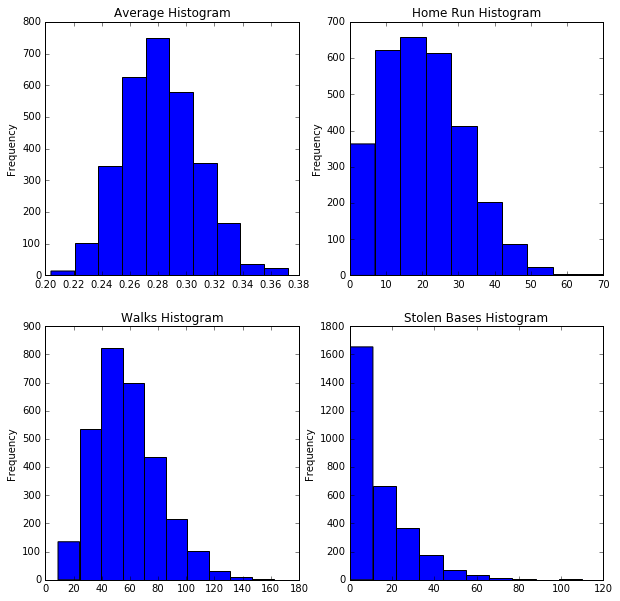

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#import batting data
batting = pd.read_csv('baseballdatabank-master/core/Batting.csv')

#Remove player seasons missing data, less than 500 at bats and years prior to 1985 (no salary info available)
#Player seasons with less than 500 at bats may not have reliable statistics (counting stats like RBI, HR, and H will be much lower for a player with fewer at bats). 
#A player with fewer at bats (possibly due to injury) will still receive their full salary.  This skews the data.
#A player generally has 600-700 at bats in a season where they remain healthy for most of the year 
batting=batting[pd.notnull(batting['AB'])]
batting=batting.drop(batting[batting.yearID<1985].index)
batting=batting.drop(batting[batting.AB<500].index)

#calculate on-base percentage, batting average and slugging percentage
batting['AVG'] = batting.H / batting.AB
batting['AVG'] = batting['AVG'].round(3) 
batting['OBP'] = (batting.H + batting.BB + batting.HBP) / (batting.AB + batting.BB + batting.HBP + batting.SF)
batting['OBP'] = batting['OBP'].round(3)
batting['SLG'] = (batting.H + batting['2B'] + 2*batting['3B']+ 2*batting.HR)/batting.AB
batting['SLG'] = batting['SLG'].round(3)

#plot a histogram for the following 4 statistics - AVG, HR, BB, SB

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

batting['AVG'].plot(kind="hist", ax=axes[0,0]); axes[0,0].set_title('Average Histogram');
batting['HR'].plot(kind="hist", ax=axes[0,1]); axes[0,1].set_title('Home Run Histogram');
batting['BB'].plot(kind="hist", ax=axes[1,0]); axes[1,0].set_title('Walks Histogram');
batting['SB'].plot(kind="hist", ax=axes[1,1]); axes[1,1].set_title('Stolen Bases Histogram');


## Working with Salary Data

Finding correlations with salary has at least 3 issues:
 
1. Salary data may be lumpy as players often sign mult-year contracts. This means that salaries will not change in direct relation to player performance. Salaries will only change significantly after their contract has expired. 
2. The league has policies that keeps player salaries artificially lower for players with fewer years experience in the major leagues.
3. Salaries have gone up significantly in recent years.

To mitigate issue number 1, a large data set with many player years is being used. To mitigate issue number 2, only players with a contract higher than the mean contract in that year are included in the calculations. To mitigate issue number 3, salaries are measured as the number of standard deviations above the mean of all salaries in that year. The code below imports the salary data and manipulates it to be grouped and standardized by year. Below the code there is a histogram that shows the normalized salaries from 1985 to 2015.

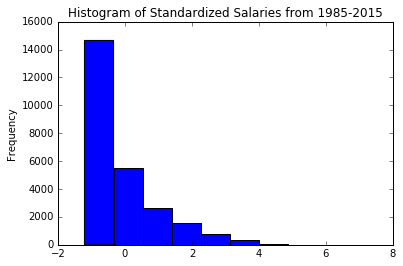

In [28]:

#import salary data
salary = pd.read_csv('baseballdatabank-master/core/Salaries.csv')


#standardize salaries
a = salary.groupby('yearID')['salary'].mean()
b = salary.groupby('yearID')['salary'].std().round(decimals=0)
salary = salary.merge(pd.DataFrame({'yearID':a.index, 'Mean_Salary':a.values}), on='yearID', how='left')
salary = salary.merge(pd.DataFrame({'yearID':b.index, 'Salary_StDev':b.values}), on='yearID', how='left')
salary['z_salary']=(salary.salary - salary.Mean_Salary)/salary.Salary_StDev

#plot a histogram of the standardized salaries
salary['z_salary'].plot(kind='hist',title='Histogram of Standardized Salaries from 1985-2015')

#remove players with salaries < mean to avoid artificially low salaries (arbitration)
salary=salary.drop(salary[salary.z_salary<0].index)




# Results

The code below merges the salary and batting data from above and calculates the correlations between salary and several batting statistics. Below the code there are 4 plots (1 for each skill

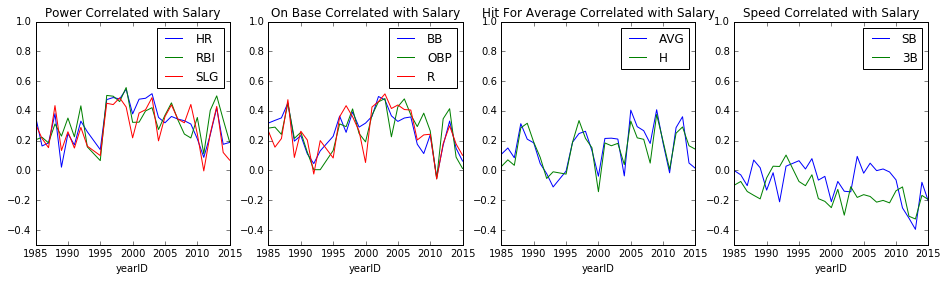

In [39]:

#merge batting and salary and drop rows where salary is not known
df = pd.merge(batting, salary, on = ['playerID','yearID'], how='left')
df=df[pd.notnull(df['z_salary'])]

#create a correlation matrix for a select set of statistics and take only the set where each statistic is correlated with the standardized salary statistic
salary_corr=df.groupby('yearID')[['z_salary','H','R','RBI','HR','BB','SLG','OBP','AVG','3B','SB']].corr()['z_salary'].unstack()

#remove the correlation of salary with itself
salary_corr.drop('z_salary',1,inplace=True)

#plot the correlation of 10 statistics with the normalized salary statistic from 1985 to 2015

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

salary_corr[['HR','RBI','SLG']].plot(ax=axes[0], ylim=(-0.5,1)); axes[0].set_title('Power Correlated with Salary');
salary_corr[['BB','OBP','R']].plot(ax=axes[1], ylim=(-0.5,1)); axes[1].set_title('On Base Correlated with Salary');
salary_corr[['AVG','H']].plot(ax=axes[2], ylim=(-0.5,1)); axes[2].set_title('Hit For Average Correlated with Salary');
salary_corr[['SB','3B']].plot(ax=axes[3], ylim=(-0.5,1)); axes[3].set_title('Speed Correlated with Salary');

mean_corr=salary_corr.mean().sort_values()

# Analysis


## Which Skills Are More Valuable

The table below shows the mean correlation between each statistic and salary. The correlations are ordered from lowest to highest.

In [4]:
print mean_corr

3B    -0.145286
SB    -0.069853
H      0.149286
AVG    0.159741
R      0.261906
BB     0.265552
OBP    0.267977
SLG    0.291076
HR     0.315459
RBI    0.322864
dtype: float64


The power statistics (RBI 0.322, HR 0.315 and SLG 0.291) have the highest correlation with salary. On-base statistics (OBP 0.268, BB 0.265 and R 0.261) have the second highest correlation with salary. Hitting for average statistics (AVG 0.160 and H 0.149) are next in order of highest correlation with salary. Speed statistics (SB -0.069 and 3B -0.145) have slightly negative correlations with salary.

From this data set it appears that the power skill is most strongly correlated with salary while the speed skill has a slight negative correlation.